In [1]:
import numpy as np
import pandas as pd
import xarray as xr
from eofs.xarray import Eof
from esem import rf_model

# data_path = './data/train_val/'
data_path = "input_data/"

min_co2 = 0.
max_co2 = 9500
def normalize_co2(data):
    return data / max_co2

def un_normalize_co2(data):
    return data * max_co2

min_ch4 = 0.
max_ch4 = 0.8
def normalize_ch4(data):
    return data / max_ch4

def un_normalize_ch4(data):
    return data * max_ch4


def create_predictor_data(data_sets, n_eofs=5):
    """
    Args:
        data_sets list(str): names of datasets
        n_eofs (int): number of eofs to create for aerosol variables
    """
        
    # Create training and testing arrays
    if isinstance(data_sets, str):
        data_sets = [data_sets]
    X = xr.concat([xr.open_dataset(data_path + f"inputs_{file}.nc") for file in data_sets], dim='time')
    X = X.assign_coords(time=np.arange(len(X.time)))

    # Compute EOFs for BC
    bc_solver = Eof(X['BC'])
    bc_eofs = bc_solver.eofsAsCorrelation(neofs=n_eofs)
    bc_pcs = bc_solver.pcs(npcs=n_eofs, pcscaling=1)

    # Compute EOFs for SO2
    so2_solver = Eof(X['SO2'])
    so2_eofs = so2_solver.eofsAsCorrelation(neofs=n_eofs)
    so2_pcs = so2_solver.pcs(npcs=n_eofs, pcscaling=1)

    # Convert to pandas
    bc_df = bc_pcs.to_dataframe().unstack('mode')
    bc_df.columns = [f"BC_{i}" for i in range(n_eofs)]

    so2_df = so2_pcs.to_dataframe().unstack('mode')
    so2_df.columns = [f"SO2_{i}" for i in range(n_eofs)]

    # Bring the emissions data back together again and normalise
    inputs = pd.DataFrame({
        "CO2": normalize_co2(X["CO2"].data),
        "CH4": normalize_ch4(X["CH4"].data)
    }, index=X["CO2"].coords['time'].data)

    # Combine with aerosol EOFs
    inputs = pd.concat([inputs, bc_df, so2_df], axis=1)
    return inputs, (so2_solver, bc_solver)

def get_test_data(file, eof_solvers, n_eofs=5):
    """
    Args:
        file str: name of datasets
        n_eofs (int): number of eofs to create for aerosol variables
        eof_solvers (Eof_so2, Eof_bc): Fitted Eof objects to use for projection
    """
        
    # Create training and testing arrays
    X = xr.open_dataset(data_path + f"inputs_{file}.nc")
        
    so2_pcs = eof_solvers[0].projectField(X["SO2"], neofs=5, eofscaling=1)
    so2_df = so2_pcs.to_dataframe().unstack('mode')
    so2_df.columns = [f"SO2_{i}" for i in range(n_eofs)]

    bc_pcs = eof_solvers[1].projectField(X["BC"], neofs=5, eofscaling=1)
    bc_df = bc_pcs.to_dataframe().unstack('mode')
    bc_df.columns = [f"BC_{i}" for i in range(n_eofs)]

    # Bring the emissions data back together again and normalise
    inputs = pd.DataFrame({
        "CO2": normalize_co2(X["CO2"].data),
        "CH4": normalize_ch4(X["CH4"].data)
    }, index=X["CO2"].coords['time'].data)

    # Combine with aerosol EOFs
    inputs = pd.concat([inputs, bc_df, so2_df], axis=1)
    return inputs


def create_predictdand_data(data_sets):
    print(f"{data_path + data_sets[0]}")
    datasets = []
    for file in data_sets:
        ds = xr.open_dataset(data_path + file)
        if 'quantile' in ds.coords:
            ds = ds.drop_vars('quantile')
        datasets.append(ds)

            
    Y = xr.concat(datasets, dim='year')
    print(Y)
    # Convert the precip values to mm/day
    Y["pr"] *= 86400
    Y["pr90"] *= 86400
    return Y


def get_rmse(truth, pred):
    weights = np.cos(np.deg2rad(truth.lat))
    return np.sqrt(((truth - pred)**2).weighted(weights).mean(['lat', 'lon'])).data

2025-11-12 10:34:07.550952: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-11-12 10:34:07.598821: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-11-12 10:34:09.042567: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [15]:
!pip install esem

Defaulting to user installation because normal site-packages is not writeable


In [2]:
!pip install eofs

Defaulting to user installation because normal site-packages is not writeable


In [2]:
train_files = ["ssp126", "historical", "ssp370"]
X_train, eof_solvers = create_predictor_data(train_files)

OSError: [Errno -101] NetCDF: HDF error: '/glade/u/home/okyang/input_data/inputs_ssp126.nc'

In [5]:
X_train

,CO2,CH4,BC_0,BC_1,BC_2,BC_3,BC_4,SO2_0,SO2_1,SO2_2,SO2_3,SO2_4
0,0.161692,0.467171,-1.255067,-0.590239,-1.276701,-0.665444,0.380421,-1.056298,-0.776608,-0.822807,-0.564175,-0.426025
1,0.165464,0.457111,-1.145539,-0.494516,-1.321590,-0.715427,0.227580,-1.022363,-0.676457,-0.678716,-0.428824,-0.272103
2,0.169257,0.447052,-1.036010,-0.398793,-1.366479,-0.765410,0.074739,-0.988428,-0.576307,-0.534625,-0.293474,-0.118182
3,0.173070,0.436992,-0.926482,-0.303070,-1.411369,-0.815394,-0.078103,-0.954492,-0.476157,-0.390534,-0.158124,0.035739
4,0.176905,0.426933,-0.816954,-0.207347,-1.456258,-0.865377,-0.230944,-0.920557,-0.376007,-0.246443,-0.022773,0.189661
...,...,...,...,...,...,...,...,...,...,...,...,...
332,0.678575,0.916497,-1.019290,0.984041,2.470178,1.450319,-0.998821,-0.963483,-0.085801,0.246237,0.409107,0.582476
333,0.686851,0.921625,-1.004593,1.004437,2.505361,1.490528,-1.022756,-0.950496,-0.069473,0.239310,0.369878,0.567690
334,0.695178,0.926752,-0.989896,1.024834,2.540544,1.530736,-1.046691,-0.937509,-0.053146,0.232383,0.330649,0.552905
335,0.703556,0.931880,-0.975199,1.045230,2.575726,1.570945,-1.070626,-0.924522,-0.036819,0.225456,0.291421,0.538120


In [5]:
ds = xr.open_dataset("input_data/NorESM2-LM_ssp370_r1i1p1f1.nc")
print(ds)
ds = xr.open_dataset("input_data/NorESM2-LM_ssp126_r1i1p1f1.nc")
print(ds)
ds = xr.open_dataset("input_data/NorESM2-LM_historical_r1i1p1f1.nc")
print(ds)


ds = xr.open_dataset("input_data/outputs_ssp126.nc")
print(ds)

OSError: [Errno -101] NetCDF: HDF error: '/glade/u/home/okyang/input_data/NorESM2-LM_ssp370_r1i1p1f1.nc'

In [7]:
tasFiles = ["NorESM2-LM_ssp370_r1i1p1f1.nc", "NorESM2-LM_ssp126_r1i1p1f1.nc", "NorESM2-LM_historical_r1i1p1f1.nc"]
#tasFiles = ["outputs_ssp126.nc"]
y_train_tas = create_predictdand_data(tasFiles)['tas'].values.reshape(-1, 96 * 144)

input_data/NorESM2-LM_ssp370_r1i1p1f1.nc
<xarray.Dataset> Size: 93MB
Dimensions:                    (year: 337, lat: 96, lon: 144)
Coordinates:
  * lat                        (lat) float64 768B -90.0 -88.11 ... 88.11 90.0
  * lon                        (lon) float64 1kB 0.0 2.5 5.0 ... 355.0 357.5
    height                     float64 8B 2.0
  * year                       (year) int64 3kB 2015 2016 2017 ... 2013 2014
Data variables:
    tas                        (year, lat, lon) float32 19MB 228.7 ... 262.2
    pr                         (year, lat, lon) float32 19MB 2.043e-06 ... 5....
    pr90                       (year, lat, lon) float64 37MB 3.294e-06 ... 8....
    diurnal_temperature_range  (year, lat, lon) float32 19MB nan nan ... 2.329


In [8]:
y_train_tas

array([[228.73613, 228.60907, 228.58513, ..., 259.05115, 259.05087,
        259.05045],
       [228.66936, 228.54283, 228.51909, ..., 260.38773, 260.38736,
        260.38693],
       [228.41997, 228.29327, 228.26949, ..., 260.66724, 260.66696,
        260.6666 ],
       ...,
       [228.97205, 228.84444, 228.82043, ..., 259.9597 , 259.95895,
        259.95813],
       [227.88148, 227.75493, 227.73114, ..., 259.0115 , 259.01236,
        259.0134 ],
       [229.30132, 229.17445, 229.15056, ..., 262.1841 , 262.18442,
        262.18478]], dtype=float32)

In [9]:
X_test = get_test_data('ssp245', eof_solvers)
Y_test = xr.open_dataset(data_path + 'outputs_ssp245.nc').compute()
tas_truth = Y_test["tas"].mean('member')

In [10]:
nan_train_mask = X_train.isna().any(axis=1).values
X_train = X_train.dropna(axis=0, how='any')
y_train_tas = y_train_tas[~nan_train_mask]
assert len(X_train) == len(y_train_tas)

nan_test_mask = X_test.isna().any(axis=1).values
X_test = X_test.dropna(axis=0, how='any')
tas_truth = tas_truth.isel(time=~xr.DataArray(nan_test_mask, dims='time'))

In [11]:
tas_truth

<xarray.DataArray 'tas' (time: 86, lat: 96, lon: 144)> Size: 5MB
array([[[1.4753824 , 1.4754995 , 1.4754333 , ..., 1.4753876 ,
         1.4754282 , 1.475413  ],
        [1.4822184 , 1.4778137 , 1.4732565 , ..., 1.4789581 ,
         1.4826254 , 1.4838715 ],
        [1.3079427 , 1.3219757 , 1.3363291 , ..., 1.2701721 ,
         1.2813873 , 1.291804  ],
        ...,
        [2.103485  , 2.1027222 , 2.104889  , ..., 2.103485  ,
         2.0991008 , 2.1009114 ],
        [2.2389019 , 2.237325  , 2.2364094 , ..., 2.23585   ,
         2.2373455 , 2.2379558 ],
        [2.358266  , 2.3552043 , 2.3497212 , ..., 2.3569438 ,
         2.3573406 , 2.3577168 ]],

       [[1.2637278 , 1.2639517 , 1.2639618 , ..., 1.2637024 ,
         1.2637075 , 1.2637634 ],
        [1.0221863 , 1.0289154 , 1.0362753 , ..., 1.0074972 ,
         1.0111135 , 1.0158285 ],
        [0.96910095, 0.99069214, 1.011495  , ..., 0.9227193 ,
         0.93724567, 0.9519043 ],
...
        [5.876943  , 5.8633933 , 5.8509727 , ..., 5.902954  ,
         5.89269   , 5.8875732 ],
        [5.9228616 , 5.913513  , 5.9022927 , ..., 5.9509583 ,
         5.9421387 , 5.930288  ],
        [5.9937644 , 5.9912515 , 5.9868774 , ..., 5.992859  ,
         5.993042  , 5.993418  ]],

       [[2.8937428 , 2.8941193 , 2.8941243 , ..., 2.8936818 ,
         2.8936818 , 2.8937123 ],
        [2.9665527 , 2.9758403 , 2.9842784 , ..., 2.9415538 ,
         2.9492798 , 2.95755   ],
        [2.906128  , 2.9335175 , 2.960673  , ..., 2.813258  ,
         2.8421783 , 2.8742268 ],
        ...,
        [4.75058   , 4.7525125 , 4.757731  , ..., 4.7245994 ,
         4.734202  , 4.74293   ],
        [5.003723  , 5.0000205 , 4.9972024 , ..., 5.0043945 ,
         5.0058494 , 5.00411   ],
        [5.266866  , 5.264038  , 5.2586465 , ..., 5.2635903 ,
         5.2644553 , 5.2655945 ]]], dtype=float32)
Coordinates:
  * lat       (lat) float64 768B -90.0 -88.11 -86.21 -84.32 ... 86.21 88.11 90.0
  * lon       (lon) float64 1kB 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
  * time      (time) int64 688B 2015 2016 2017 2018 2019 ... 2097 2098 2099 2100
    quantile  float64 8B 0.9

In [11]:
train_CO2_mean, train_CO2_std = X_train['CO2'].mean(), X_train['CO2'].std()
train_CH4_mean, train_CH4_std = X_train['CH4'].mean(), X_train['CH4'].std()

X_train.CO2 = (X_train.CO2 - train_CO2_mean) / train_CO2_std
X_train.CH4 = (X_train.CH4 - train_CH4_mean) / train_CH4_std

X_test.CO2 = (X_test.CO2 - train_CO2_mean) / train_CO2_std
X_test.CH4 = (X_test.CH4 - train_CH4_mean) / train_CH4_std

In [12]:
train_tas_mean, train_tas_std = y_train_tas.mean(), y_train_tas.std()
y_train_tas = (y_train_tas - train_tas_mean) / train_tas_std

In [13]:
!pip install gpflow

Defaulting to user installation because normal site-packages is not writeable


In [14]:
import gpflow

2025-11-12 00:24:27.032487: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-11-12 00:24:27.103844: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-11-12 00:24:28.427286: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [15]:
kernel_CO2 = gpflow.kernels.Matern32(active_dims=[0])
kernel_CH4 = gpflow.kernels.Matern32(active_dims=[1])

kernel_BC = gpflow.kernels.Matern32(lengthscales=5 * [1.], active_dims=[2, 3, 4, 5, 6])
kernel_SO2 = gpflow.kernels.Matern32(lengthscales=5 * [1.], active_dims=[7, 8, 9, 10, 11])

kernel = kernel_CO2 + kernel_CH4 + kernel_BC + kernel_SO2

2025-11-12 00:24:31.586135: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


In [16]:
np.random.seed(5)
mean = gpflow.mean_functions.Constant()
model = gpflow.models.GPR(data=(X_train.astype(np.float64), 
                                y_train_tas.astype(np.float64)),
                          kernel=kernel,
                          mean_function=mean)

In [17]:
opt = gpflow.optimizers.Scipy()

# Train model
opt.minimize(
    model.training_loss,
    variables=model.trainable_variables,
    options=dict(disp=True, maxiter=1000),
)

  message: CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH
  success: True
   status: 0
      fun: -8649652.554770287
        x: [ 2.619e+01  5.649e-01 ... -6.890e+00 -3.343e-02]
      nit: 315
      jac: [ 9.271e+00 -1.043e+01 ... -3.333e+01 -1.581e+01]
     nfev: 374
     njev: 374
 hess_inv: <18x18 LbfgsInvHessProduct with dtype=float64>

In [18]:
standard_posterior_mean, standard_posterior_var = model.predict_y(X_test.values)
posterior_mean = standard_posterior_mean * train_tas_std + train_tas_mean
posterior_std = np.sqrt(standard_posterior_var) * train_tas_std

In [19]:
posterior_tas = np.reshape(posterior_mean, [86, 96, 144])
posterior_tas_std = np.reshape(posterior_std, [86, 96, 144])

posterior_tas_data = xr.DataArray(posterior_tas, dims=tas_truth.dims, coords=tas_truth.coords)
posterior_tas_std_data = xr.DataArray(posterior_tas_std, dims=tas_truth.dims, coords=tas_truth.coords)

In [20]:
print(f"RMSE at 2050: {get_rmse(tas_truth[35], posterior_tas_data[35])}")
print(f"RMSE at 2100: {get_rmse(tas_truth[85], posterior_tas_data[85])}")
print(f"RMSE 2045-2055: {get_rmse(tas_truth[30:41], posterior_tas_data[30:41]).mean()}")
print(f"RMSE 2090-2100: {get_rmse(tas_truth[75:], posterior_tas_data[75:]).mean()}")
print(f"RMSE 2050-2100: {get_rmse(tas_truth[35:], posterior_tas_data[35:]).mean()}")

RMSE at 2050: 287.72692111387147
RMSE at 2100: 288.1637997254478
RMSE 2045-2055: 287.68550559366014
RMSE 2090-2100: 288.15010174080413
RMSE 2050-2100: 287.9903548517817


In [21]:
from matplotlib import colors
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

[Text(0.5, 1.0, 'Difference')]

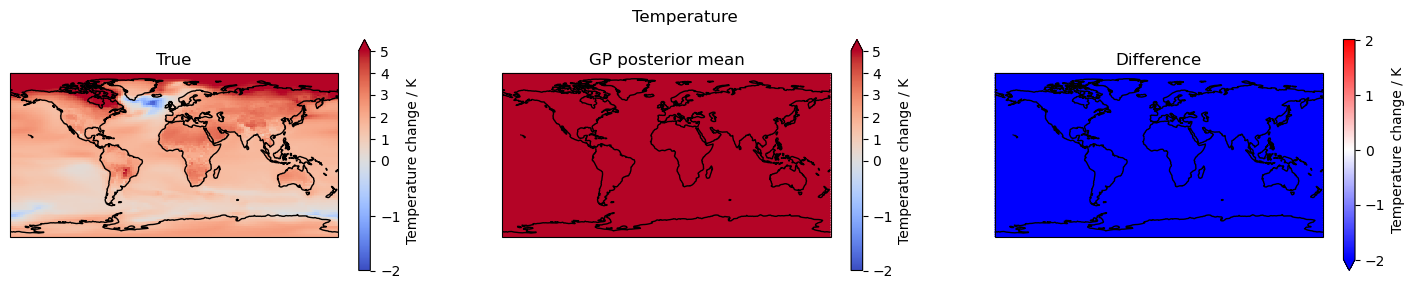

In [22]:
divnorm = colors.TwoSlopeNorm(vmin=-2., vcenter=0., vmax=5)
diffnorm = colors.TwoSlopeNorm(vmin=-2., vcenter=0., vmax=2)

## Temperature
proj = ccrs.PlateCarree()
fig = plt.figure(figsize=(18, 3))
fig.suptitle('Temperature')

# Test
plt.subplot(131, projection=proj)
tas_truth.sel(time=slice(2050,None)).mean('time').plot(cmap="coolwarm", norm=divnorm,
                              cbar_kwargs={"label":"Temperature change / K"})
plt.gca().coastlines()
plt.setp(plt.gca(), title='True')

# Emulator
plt.subplot(132, projection=proj)
posterior_tas_data.sel(time=slice(2050,None)).mean('time').plot(cmap="coolwarm", norm=divnorm,
                       cbar_kwargs={"label":"Temperature change / K"})
plt.gca().coastlines()
plt.setp(plt.gca(), title='GP posterior mean')

# Difference
difference = tas_truth - posterior_tas_data
plt.subplot(133, projection=proj)
difference.sel(time=slice(2050,None)).mean('time').plot(cmap="bwr", norm=diffnorm,
                cbar_kwargs={"label":"Temperature change / K"})
plt.gca().coastlines()
plt.setp(plt.gca(), title='Difference')

In [23]:
model

name,class,transform,prior,trainable,shape,dtype,value
GPR.mean_function.c,Parameter,Identity,,True,"(1,)",float64,[-0.03342866]
GPR.kernel.kernels[0].variance,Parameter,Softplus,,True,(),float64,1.01495
GPR.kernel.kernels[0].lengthscales,Parameter,Softplus,,True,(),float64,26.19327
GPR.kernel.kernels[1].variance,Parameter,Softplus,,True,(),float64,0.7538825490882872
GPR.kernel.kernels[1].lengthscales,Parameter,Softplus,,True,(),float64,19.29944
GPR.kernel.kernels[2].variance,Parameter,Softplus,,True,(),float64,0.0003315532374876187
GPR.kernel.kernels[2].lengthscales,Parameter,Softplus,,True,"(5,)",float64,"[0.0717019, 28.20798, 0.18851706..."
GPR.kernel.kernels[3].variance,Parameter,Softplus,,True,(),float64,0.0004481426594474543
GPR.kernel.kernels[3].lengthscales,Parameter,Softplus,,True,"(5,)",float64,"[0.79538282, 0.50547473, 0.60941701..."
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,0.0010181439385394584


In [14]:
train_files = [ "historical", "ssp126", "ssp370"]
tasFiles = ["NorESM2-LM_ssp370_r1i1p1f1.nc", "NorESM2-LM_ssp126_r1i1p1f1.nc", "NorESM2-LM_historical_r1i1p1f1.nc"]
# Create training and testing arrays
X, solvers = create_predictor_data(train_files)
Y = create_predictdand_data(tasFiles)

input_data/NorESM2-LM_ssp370_r1i1p1f1.nc
<xarray.Dataset> Size: 93MB
Dimensions:                    (year: 337, lat: 96, lon: 144)
Coordinates:
  * lat                        (lat) float64 768B -90.0 -88.11 ... 88.11 90.0
  * lon                        (lon) float64 1kB 0.0 2.5 5.0 ... 355.0 357.5
    height                     float64 8B 2.0
  * year                       (year) int64 3kB 2015 2016 2017 ... 2013 2014
Data variables:
    tas                        (year, lat, lon) float32 19MB 228.7 ... 262.2
    pr                         (year, lat, lon) float32 19MB 2.043e-06 ... 5....
    pr90                       (year, lat, lon) float64 37MB 3.294e-06 ... 8....
    diurnal_temperature_range  (year, lat, lon) float32 19MB nan nan ... 2.329


In [22]:
rf_tas = rf_model(X, Y['tas'], random_state=0, bootstrap=True, max_features=0.3, **{'n_estimators': 250, 'min_samples_split': 5, 'min_samples_leaf': 7,  'max_depth': 5,})

In [23]:
rf_tas.train()

In [18]:
Y_test = xr.open_dataset(data_path + 'outputs_ssp245.nc').compute()

In [30]:
Y_test_tas = Y_test["tas"].mean('member')

In [31]:
Y_test_tas

<xarray.DataArray 'tas' (time: 86, lat: 96, lon: 144)> Size: 5MB
array([[[1.4753824 , 1.4754995 , 1.4754333 , ..., 1.4753876 ,
         1.4754282 , 1.475413  ],
        [1.4822184 , 1.4778137 , 1.4732565 , ..., 1.4789581 ,
         1.4826254 , 1.4838715 ],
        [1.3079427 , 1.3219757 , 1.3363291 , ..., 1.2701721 ,
         1.2813873 , 1.291804  ],
        ...,
        [2.103485  , 2.1027222 , 2.104889  , ..., 2.103485  ,
         2.0991008 , 2.1009114 ],
        [2.2389019 , 2.237325  , 2.2364094 , ..., 2.23585   ,
         2.2373455 , 2.2379558 ],
        [2.358266  , 2.3552043 , 2.3497212 , ..., 2.3569438 ,
         2.3573406 , 2.3577168 ]],

       [[1.2637278 , 1.2639517 , 1.2639618 , ..., 1.2637024 ,
         1.2637075 , 1.2637634 ],
        [1.0221863 , 1.0289154 , 1.0362753 , ..., 1.0074972 ,
         1.0111135 , 1.0158285 ],
        [0.96910095, 0.99069214, 1.011495  , ..., 0.9227193 ,
         0.93724567, 0.9519043 ],
...
        [5.876943  , 5.8633933 , 5.8509727 , ..., 5.902954  ,
         5.89269   , 5.8875732 ],
        [5.9228616 , 5.913513  , 5.9022927 , ..., 5.9509583 ,
         5.9421387 , 5.930288  ],
        [5.9937644 , 5.9912515 , 5.9868774 , ..., 5.992859  ,
         5.993042  , 5.993418  ]],

       [[2.8937428 , 2.8941193 , 2.8941243 , ..., 2.8936818 ,
         2.8936818 , 2.8937123 ],
        [2.9665527 , 2.9758403 , 2.9842784 , ..., 2.9415538 ,
         2.9492798 , 2.95755   ],
        [2.906128  , 2.9335175 , 2.960673  , ..., 2.813258  ,
         2.8421783 , 2.8742268 ],
        ...,
        [4.75058   , 4.7525125 , 4.757731  , ..., 4.7245994 ,
         4.734202  , 4.74293   ],
        [5.003723  , 5.0000205 , 4.9972024 , ..., 5.0043945 ,
         5.0058494 , 5.00411   ],
        [5.266866  , 5.264038  , 5.2586465 , ..., 5.2635903 ,
         5.2644553 , 5.2655945 ]]], dtype=float32)
Coordinates:
  * lat       (lat) float64 768B -90.0 -88.11 -86.21 -84.32 ... 86.21 88.11 90.0
  * lon       (lon) float64 1kB 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
  * time      (time) int64 688B 2015 2016 2017 2018 2019 ... 2097 2098 2099 2100
    quantile  float64 8B 0.9

In [24]:
m_out_tas, _ = rf_tas.predict(X_test)

In [28]:
m_out_tas

<xarray.DataArray 'Emulated tas' (sample: 86, lat: 96, lon: 144)> Size: 10MB
array([[[229.21977008, 229.0929893 , 229.06916584, ..., 229.2620438 ,
         229.25888111, 229.24724736],
        [227.35023034, 227.06661044, 226.95687533, ..., 227.73601236,
         227.62251061, 227.50631779],
        [228.0579991 , 227.73931748, 227.5914772 , ..., 229.05074626,
         228.84139923, 228.5327676 ],
        ...,
        [260.16501905, 260.24484441, 260.31516846, ..., 259.91248341,
         260.00656097, 260.07688175],
        [260.09481256, 260.12481648, 260.15581254, ..., 259.99876852,
         260.03121053, 260.07223057],
        [260.08598517, 260.08953367, 260.09539389, ..., 260.08678748,
         260.0865697 , 260.08630206]],

       [[229.14986312, 229.02308295, 228.99925975, ..., 229.19213735,
         229.18897427, 229.17734066],
        [227.27698853, 226.99336908, 226.8836424 , ..., 227.66303421,
         227.54943607, 227.43315363],
        [227.98857977, 227.6696288 , 227.52153476, ..., 228.9826297 ,
         228.77284233, 228.4638464 ],
...
        [258.2180317 , 258.3109517 , 258.39252756, ..., 257.92915593,
         258.03636289, 258.11645412],
        [258.07074756, 258.10561109, 258.14175948, ..., 257.9618667 ,
         257.9984046 , 258.0450847 ],
        [257.98904148, 257.99420538, 258.00282685, ..., 257.99068928,
         257.99024179, 257.98969342]],

       [[228.45065656, 228.32389095, 228.30007214, ..., 228.49293016,
         228.48976651, 228.47813217],
        [226.50399541, 226.21978595, 226.10942146, ..., 226.89278447,
         226.77831249, 226.66102504],
        [227.21394267, 226.89087093, 226.73984328, ..., 228.22355257,
         228.00868224, 227.69464597],
        ...,
        [258.24417103, 258.33692527, 258.41834854, ..., 257.95584295,
         258.0628587 , 258.14278256],
        [258.09674245, 258.13159813, 258.1677578 , ..., 257.98787812,
         258.02439886, 258.07107167],
        [258.01593399, 258.02108918, 258.02969332, ..., 258.01756565,
         258.01712249, 258.01657952]]])
Coordinates:
  * lat      (lat) float64 768B -90.0 -88.11 -86.21 -84.32 ... 86.21 88.11 90.0
  * lon      (lon) float64 1kB 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
  * sample   (sample) int64 688B 0 1 2 3 4 5 6 7 8 ... 78 79 80 81 82 83 84 85
Attributes:
    standard_name:  air_temperature
    long_name:      Near-Surface Air Temperature
    comment:        near-surface (usually, 2 meter) air temperature
    units:          K
    original_name:  TREFHT
    cell_methods:   area: time: mean
    cell_measures:  area: areacella
    history:        2019-12-08T14:43:56Z altered by CMOR: Treated scalar dime...

In [32]:
print(f"RMSE: {get_rmse(Y_test_tas[35:], m_out_tas[35:]).mean()}")
print("\n")

RMSE: 286.6691687341393




In [36]:
# Y['pr'] = Y['pr'].interpolate_na(dim='lat', method='linear')
# Y['pr'] = Y['pr'].interpolate_na(dim='lon', method='linear')

In [68]:
Y['pr'] = Y['pr'].fillna(0)

In [69]:
print(np.isnan(Y['pr']).any())

<xarray.DataArray 'pr' ()> Size: 1B
array(False)
Coordinates:
    height   float64 8B 2.0


In [57]:
Y['pr']
Y['pr'].shape

(337, 96, 144)

In [71]:
rf_pr = rf_model(X, Y['pr'], random_state=0, bootstrap=True, max_features=0.3, **{'n_estimators': 150, 'min_samples_split': 15, 'min_samples_leaf': 8,'max_depth': 40,})
rf_pr.train()

In [72]:
m_out_pr, _ = rf_pr.predict(X_test)

In [73]:
Y_test_pr = Y_test['pr'].mean("member").fillna(0)

In [74]:
print(f"RMSE: {get_rmse(Y_test_pr[35:], m_out_pr[35:]).mean()}")
print("\n")

RMSE: 3.4081703462243973




In [76]:
Y['pr90'] = Y['pr90'].fillna(0)

In [77]:
rf_pr90 = rf_model(X, Y['pr90'], random_state=0, bootstrap=True, max_features=0.3, **{'n_estimators': 150, 'min_samples_split': 15, 'min_samples_leaf': 8,'max_depth': 40,})
rf_pr90.train()

In [78]:
Y_test_pr90 = Y_test["pr90"]
Y_test_pr90 = Y_test['pr'].mean("member").fillna(0)

m_out_pr90, _ = rf_pr90.predict(X_test)

In [ ]:
print(f"RMSE: {get_rmse(Y_test_pr90[35:], m_out_pr90[35:]).mean()}")
print("\n")